Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.

Epoch 1/10


1256/1256 [==============================] - 346s 271ms/step - loss: 0.2476 - accuracy: 0.8968 - val_loss: 0.1055 - val_accuracy: 0.9605
Epoch 2/10
1256/1256 [==============================] - 228s 181ms/step - loss: 0.1465 - accuracy: 0.9426 - val_loss: 0.1467 - val_accuracy: 0.9503
Epoch 3/10
1256/1256 [==============================] - 242s 193ms/step - loss: 0.1057 - accuracy: 0.9609 - val_loss: 0.1530 - val_accuracy: 0.9313
Epoch 4/10
1256/1256 [==============================] - 241s 192ms/step - loss: 0.0860 - accuracy: 0.9693 - val_loss: 0.0448 - val_accuracy: 0.9833
Epoch 5/10
1256/1256 [==============================] - 241s 191ms/step - loss: 0.0690 - accuracy: 0.9760 - val_loss: 0.2948 - val_accuracy: 0.9285
Epoch 6/10
1256/1256 [==============================] - 242s 192ms/step - loss: 0.0619 - accuracy: 0.9778 - val_loss: 0.0885 - val

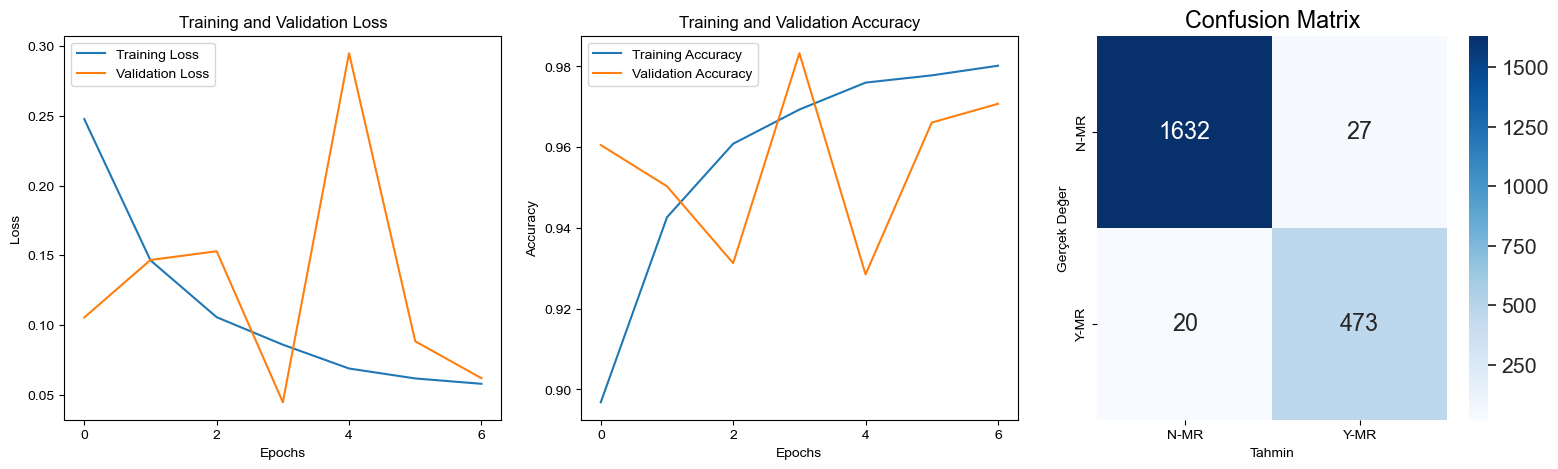


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1659
           1       0.95      0.96      0.95       493

    accuracy                           0.98      2152
   macro avg       0.97      0.97      0.97      2152
weighted avg       0.98      0.98      0.98      2152



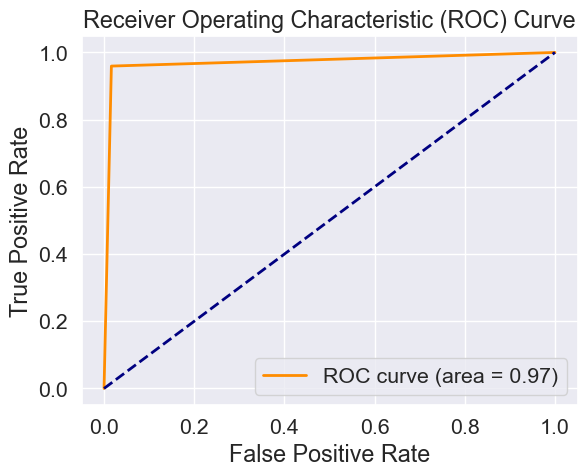

In [18]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Early stopping callback'i oluşturma
early_stopping = EarlyStopping(
    monitor='val_loss',  # Takip edilecek metrik (örneğin, doğrulama kaybı)
    patience=3,  # Metrik iyileşmediğinde veya durduğunda beklenen epoch sayısı
    restore_best_weights=True  # En iyi ağırlıkları geri yükleme
)

# Define image dataset
# why do we rescale?
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)

# CNN modelini oluşturma
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_dataset.num_classes, activation='softmax')
])

# Modeli derleme
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model eğitimi
history_cnn = cnn_model.fit(train_dataset, epochs=10, validation_data=validation, callbacks=[early_stopping, cnn_checkpoint])

# Eğitim ve doğrulama kaybı ve doğruluğu görselleştirme
plt.figure(figsize=(16, 5))

# Eğitim ve doğrulama kaybı
plt.subplot(1, 3, 1)
plt.plot(history_cnn.history['loss'], label='Training Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Eğitim ve doğrulama doğruluğu
plt.subplot(1, 3, 2)
plt.plot(history_cnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Confusion Matrix
predictions_cnn = cnn_model.predict(test_dataset)
y_pred_cnn = np.argmax(predictions_cnn, axis=1)
y_true_cnn = test_dataset.labels
conf_matrix_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)

# Karışıklık matrisini görselleştirme
plt.subplot(1, 3, 3)
sns.set(font_scale=1.4)  # Font ölçeğini ayarla
sns.heatmap(conf_matrix_cnn, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['N-MR', 'Y-MR'],
            yticklabels=['N-MR', 'Y-MR'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek Değer')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

# Classification Report
class_report_cnn = classification_report(y_true_cnn, y_pred_cnn)
print("\nClassification Report:")
print(class_report_cnn)

# ROC Eğrisi ve AUC
fpr_cnn, tpr_cnn, _ = roc_curve(y_true_cnn, y_pred_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

plt.figure()
plt.plot(fpr_cnn, tpr_cnn, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_cnn)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

cnn_checkpoint = ModelCheckpoint('CNN_model.keras', verbose=1, save_best_only=True)


In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define image dataset
WIDTH, HEIGHT = 128, 128
image_generator = ImageDataGenerator(rescale=1/255, validation_split=0, shear_range=0.25, horizontal_flip=True, rotation_range=20)

train_dataset = image_generator.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\train",
    shuffle=True,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

image_generator_submission = ImageDataGenerator(rescale=1/255, validation_split=0.5)
validation = image_generator_submission.flow_from_directory(
    batch_size=8,
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="training",
    class_mode='categorical'
)

test_dataset = image_generator_submission.flow_from_directory(
    directory=r"C:\Users\User\Desktop\YenivEeri\test",
    shuffle=False,
    target_size=(WIDTH, HEIGHT),
    subset="validation",
    class_mode=None
)



Found 10042 images belonging to 2 classes.
Found 2154 images belonging to 2 classes.
Found 2152 images belonging to 2 classes.


68/68 [==============================] - 4s 63ms/step


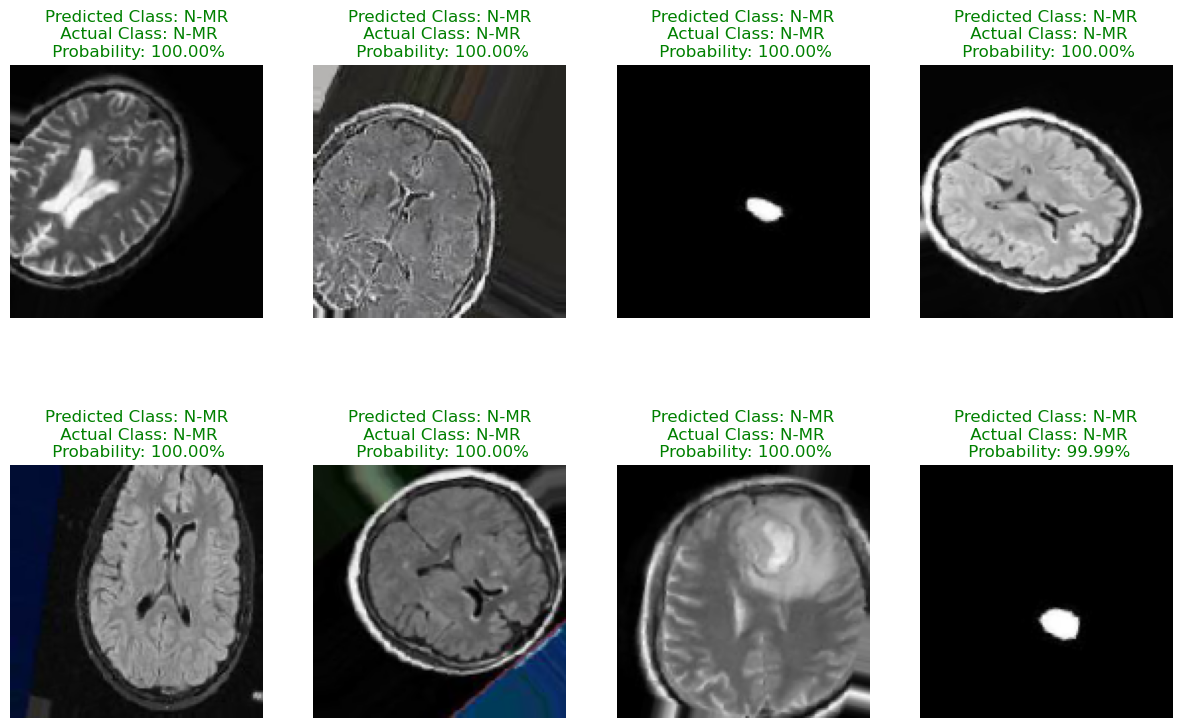

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model


cnn_model=load_model("CNN_model.keras")




cnn_predictions=cnn_model.predict(test_dataset)




cnn_true_classes=test_dataset.classes


categories={0:'N-MR', 1:'Y-MR'}
cnn_predicted_classes = np.argmax(cnn_predictions, axis=1)

predicted_classes = np.argmax(cnn_predictions, axis=1)  # En yüksek olasılığa sahip sınıfları al
prediction_probabilities = np.max(cnn_predictions, axis=1)  # En yüksek olasılıkları al
batch_1_img = train_dataset[0]
plt.figure(figsize=(15,15))
for i in range(8):
    plt.subplot(5,4,i+1)
    plt.imshow(batch_1_img[0][i])
    predicted_class_label=categories[cnn_predicted_classes[i]]
    actual_class_label=categories[cnn_true_classes[i]]

    if cnn_predicted_classes[i] == cnn_true_classes[i]:
        title_color='green'
    else:
        title_color='red'

    prediction_probability = prediction_probabilities[i] * 100

    title = f'Predicted Class: {predicted_class_label}\n Actual Class: {actual_class_label}\n Probability: {prediction_probability:.2f}%'
    plt.title(title,color=title_color)
    plt.axis('off')
plt.subplots_adjust(top=1.4)
plt.show()
